# Prior Predictive Checking

In [7]:
import arviz as az
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
from jax import random
from numpyro.infer import Predictive

# Use seaborn for nicer plots
import seaborn as sns
sns.set(style="darkgrid")


RANDOM_SEED = 42
rng_key = random.PRNGKey(RANDOM_SEED)


def model_bad_priors(y=None):
    """Define a model with vague priors that do not consider domain knowledge."""
    mu = numpyro.sample("mu", dist.Normal(0, 100))
    sigma = numpyro.sample("sigma", dist.HalfNormal(100))
    numpyro.sample("y_obs", dist.Normal(mu, sigma), obs=y)


def model_better_priors(y=None):
    """Define a model with weakly informative priors based on HCI domain knowledge,
    which is that task completion times are typically around a few seconds.
    """
    mu = numpyro.sample("mu", dist.Normal(1.5, 0.5))
    sigma = numpyro.sample("sigma", dist.HalfNormal(0.5))
    numpyro.sample("y_obs", dist.Normal(mu, sigma), obs=y)

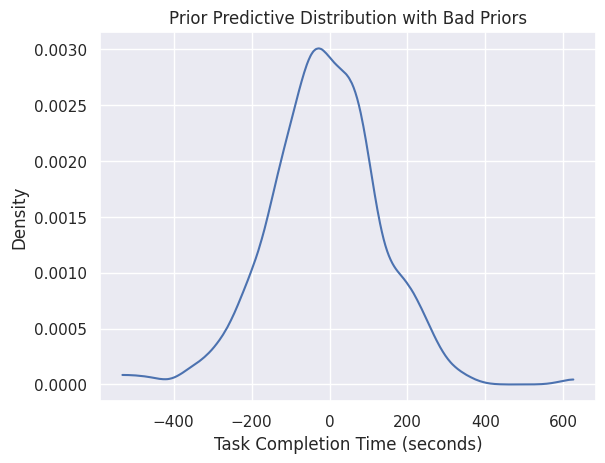

In [8]:
# Prior predictive checking with bad priors
rng_key, subkey = random.split(rng_key)
prior_predictive_bad = Predictive(model_bad_priors, num_samples=500)
prior_samples_bad = prior_predictive_bad(subkey)

# Convert to ArviZ InferenceData for easier plotting
idata_bad = az.from_dict(
    prior_predictive={"y_obs": prior_samples_bad["y_obs"][None, ...]},
    prior={
        "mu": prior_samples_bad["mu"][None, ...],
        "sigma": prior_samples_bad["sigma"][None, ...],
    },
)

# Plot prior predictive distribution
az.plot_dist(idata_bad.prior_predictive["y_obs"], kind="kde")
plt.title("Prior Predictive Distribution with Bad Priors")
plt.xlabel("Task Completion Time (seconds)")
plt.ylabel("Density")
plt.show()

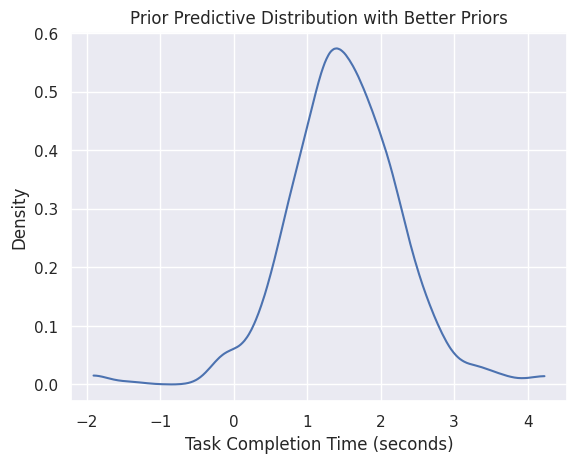

In [9]:
# Prior Predictive Check with Good Priors
rng_key, subkey = random.split(rng_key)
prior_predictive_better = Predictive(model_better_priors, num_samples=500)
prior_samples_better = prior_predictive_better(subkey)

# Convert to ArviZ InferenceData
idata_better = az.from_dict(
    prior_predictive={"y_obs": prior_samples_better["y_obs"][None, ...]},
    prior={
        "mu": prior_samples_better["mu"][None, ...],
        "sigma": prior_samples_better["sigma"][None, ...],
    },
)

# Plot prior predictive distribution
az.plot_dist(idata_better.prior_predictive["y_obs"], kind="kde")
plt.title("Prior Predictive Distribution with Better Priors")
plt.xlabel("Task Completion Time (seconds)")
plt.ylabel("Density")
plt.show()

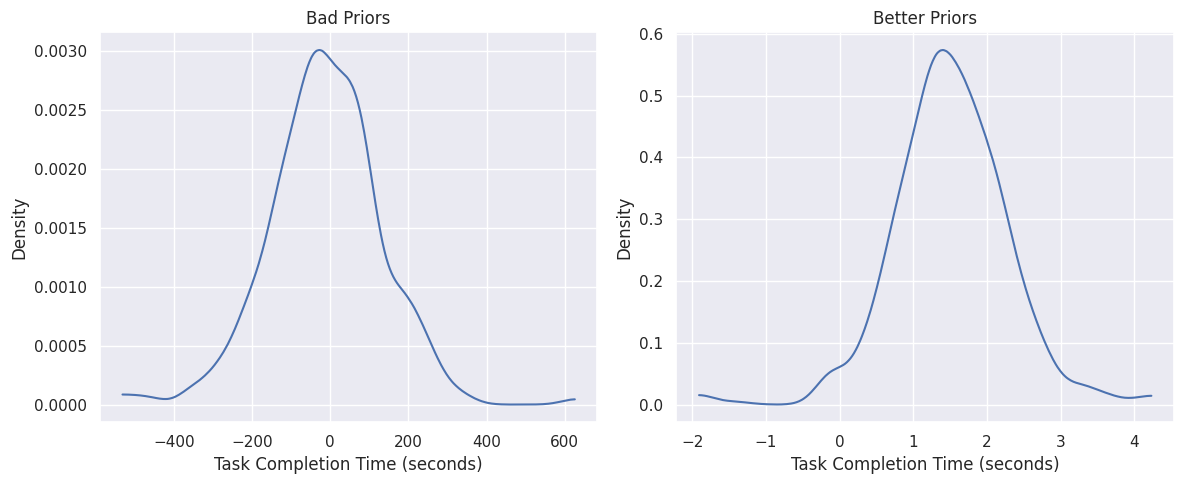

In [11]:
# Plot the two prior predictive distributions side by side for comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
az.plot_dist(idata_bad.prior_predictive["y_obs"], kind="kde", ax=axes[0])
axes[0].set_title("Bad Priors")
axes[0].set_xlabel("Task Completion Time (seconds)")
axes[0].set_ylabel("Density")
az.plot_dist(idata_better.prior_predictive["y_obs"], kind="kde", ax=axes[1])
axes[1].set_title("Better Priors")
axes[1].set_xlabel("Task Completion Time (seconds)")
axes[1].set_ylabel("Density")
plt.tight_layout()
plt.show()